### Import libraries and Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected, degree
from sklearn.neighbors import kneighbors_graph
import scipy.sparse as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### Generate points on Unit Sphere

In [2]:
# Parameters
num_points = 500

# Generate points using spherical coordinates
# [0, pi]
theta = np.random.uniform(0, np.pi, num_points)
# [0, 2pi]
phi = np.random.uniform(0, 2 * np.pi, num_points)

x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

# Shape: (500, 3)
points = np.stack([x, y, z], axis=1)

# Compute ground truth f = x^2 + y^2 + z^2 ≈ 1, with noise
# Should be ≈ 1 on unit sphere
f = x**2 + y**2 + z**2
# Noise ~ N(0, 0.1)
noise = np.random.normal(0, 0.1, num_points)
f = f + noise
# Shape: (500, 1)
ground_truth = f.reshape(-1, 1)

# Print shapes to verify
print(f"Points shape: {points.shape}")
print(f"Ground truth shape: {ground_truth.shape}")

Points shape: (500, 3)
Ground truth shape: (500, 1)


In [ ]:
# Sample of ground truth for checking
ground_truth[:5]

array([[1.0177701 ],
       [0.86646556],
       [1.03801979],
       [1.06105857],
       [1.05597904]])

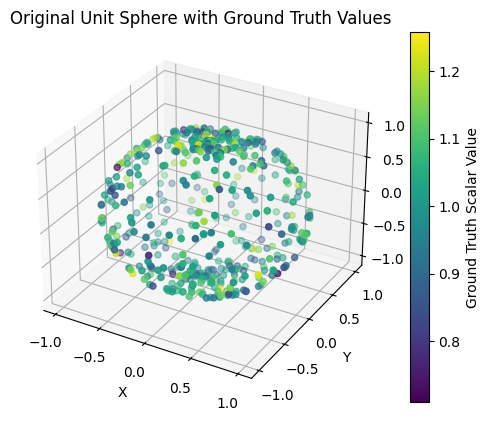

In [21]:
# Visualize the original unit sphere with ground truth values
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=ground_truth.flatten(), cmap='viridis')
plt.colorbar(sc, label='Ground Truth Scalar Value')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Original Unit Sphere with Ground Truth Values')
plt.savefig('ground_truth.png')
plt.show()

In [39]:
# Compute the range of ground truth values
ground_truth_min = ground_truth.min()
ground_truth_max = ground_truth.max()
print(f"Ground Truth Range: {ground_truth_min:.5f} to {ground_truth_max:.5f}")

Ground Truth Range: 0.71037 to 1.25797


### Construct KNN Graph

In [3]:
# Parameters
k = 8

# Compute k-NN graph (directed)
adj_matrix = kneighbors_graph(points, n_neighbors=k, mode='connectivity', include_self=False)
# Convert to COO format
adj_matrix = adj_matrix.tocoo()

# Extract edge indices
row, col = adj_matrix.row, adj_matrix.col
edge_index = torch.tensor([row, col], dtype=torch.long)

# Make the graph undirected
edge_index = to_undirected(edge_index, num_nodes=points.shape[0])

# Print edge index shape
print(f"Edge index shape: {edge_index.shape}")

Edge index shape: torch.Size([2, 4748])


C:\Users\rocky\AppData\Local\Temp\ipykernel_25020\2358994792.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  edge_index = torch.tensor([row, col], dtype=torch.long)


### Define the GCN Model

We define a 2-layer GCN with the architecture:

- Input: (500, 3) 3D coordinates.
- Layer 1: (3, 16) with ReLU activation.
- Layer 2: (16, 1) for scalar prediction (no activation).

In [4]:
# Define the GCN class
class GCN(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=16, out_channels=1):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # No activation for regression
        x = self.conv2(x, edge_index)
        return x

# Instantiate the model
model_float32 = GCN().float()
model_float64 = GCN().double()

# Print the model architecture
print(model_float32)

GCN(
  (conv1): GCNConv(3, 16)
  (conv2): GCNConv(16, 1)
)


### Train the GCN in Float32

We train the GCN in float32 precision for 100 epochs using the Adam optimizer, minimizing the mean squared error (MSE).

In [5]:
# Prepare data for float32
data_float32 = Data(
    x=torch.tensor(points, dtype=torch.float),
    edge_index=edge_index,
    y=torch.tensor(ground_truth, dtype=torch.float)
)

# Training parameters
num_epochs = 100
optimizer = torch.optim.Adam(model_float32.parameters(), lr=0.01)

# Train the model
model_float32.train()
losses_float32 = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    out = model_float32(data_float32.x, data_float32.edge_index)
    loss = F.mse_loss(out, data_float32.y)
    loss.backward()
    optimizer.step()
    losses_float32.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss (float32): {loss.item():.6f}")

# Compute final MSE
model_float32.eval()
with torch.no_grad():
    pred_float32 = model_float32(data_float32.x, data_float32.edge_index)
mse_float32 = F.mse_loss(pred_float32, data_float32.y).item()
print(f"Final MSE (float32): {mse_float32:.10f}")

Epoch 10/100, Loss (float32): 0.948969
Epoch 20/100, Loss (float32): 0.369289
Epoch 30/100, Loss (float32): 0.170303
Epoch 40/100, Loss (float32): 0.096176
Epoch 50/100, Loss (float32): 0.039234
Epoch 60/100, Loss (float32): 0.021245
Epoch 70/100, Loss (float32): 0.019306
Epoch 80/100, Loss (float32): 0.017203
Epoch 90/100, Loss (float32): 0.016106
Epoch 100/100, Loss (float32): 0.015381
Final MSE (float32): 0.0153041556


In [40]:
# Compute the range of single precision predictions
pred_float32_min = pred_float32.min().item()
pred_float32_max = pred_float32.max().item()
print(f"Single Precision Prediction Range: {pred_float32_min:.5f} to {pred_float32_max:.5f}")

Single Precision Prediction Range: 0.84640 to 1.21998


### Train the GCN in Float64

We train the GCN in float64 precision for 100 epochs, following the same process as in float32.

In [6]:
# Prepare data for float64
data_float64 = Data(
    x=torch.tensor(points, dtype=torch.double),
    edge_index=edge_index,
    y=torch.tensor(ground_truth, dtype=torch.double)
)

# Training parameters
optimizer = torch.optim.Adam(model_float64.parameters(), lr=0.01)

# Train the model
model_float64.train()
losses_float64 = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    out = model_float64(data_float64.x, data_float64.edge_index)
    loss = F.mse_loss(out, data_float64.y)
    loss.backward()
    optimizer.step()
    losses_float64.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss (float64): {loss.item():.6f}")

# Compute final MSE
model_float64.eval()
with torch.no_grad():
    pred_float64 = model_float64(data_float64.x, data_float64.edge_index)
mse_float64 = F.mse_loss(pred_float64, data_float64.y).item()
print(f"Final MSE (float64): {mse_float64:.10f}")

Epoch 10/100, Loss (float64): 0.694290
Epoch 20/100, Loss (float64): 0.218413
Epoch 30/100, Loss (float64): 0.059464
Epoch 40/100, Loss (float64): 0.038201
Epoch 50/100, Loss (float64): 0.030317
Epoch 60/100, Loss (float64): 0.023024
Epoch 70/100, Loss (float64): 0.020273
Epoch 80/100, Loss (float64): 0.017772
Epoch 90/100, Loss (float64): 0.015922
Epoch 100/100, Loss (float64): 0.014678
Final MSE (float64): 0.0145649973


In [41]:
# Compute the range of double precision predictions
pred_float64_min = pred_float64.min().item()
pred_float64_max = pred_float64.max().item()
print(f"Double Precision Prediction Range: {pred_float64_min:.5f} to {pred_float64_max:.5f}")

Double Precision Prediction Range: 0.85257 to 1.28046


### Compute MAE Between Float32 and Float64 Predictions

We compute the mean absolute error (MAE) between the predictions from the float32 and float64 models.

In [7]:
# Compute MAE
mae = torch.mean(torch.abs(pred_float32.double() - pred_float64)).item()
print(f"MAE between float32 and float64 predictions: {mae:.10f}")

MAE between float32 and float64 predictions: 0.0476326102


### Compute Rounding Error

We compute the rounding error by forward-passing the float64 model in both float64 and float32 precision and calculating the difference.

In [8]:
# Forward pass the float64 model in float32 precision
model_float64_float32 = GCN().float()
model_float64_float32.load_state_dict(model_float64.state_dict())
model_float64_float32.eval()
with torch.no_grad():
    pred_float64_in_float32 = model_float64_float32(data_float32.x, data_float32.edge_index).double()

# Compute rounding error
rounding_error = torch.mean(torch.abs(pred_float64 - pred_float64_in_float32)).item()
print(f"Rounding error: {rounding_error:.10f}")

Rounding error: 0.0000000494


### Analyze Graph Properties - Number of Edges and Sparsity

We compute the number of undirected edges and the sparsity of the adjacency matrix.

In [9]:
# Number of undirected edges
# Each edge stored twice
num_undirected_edges = edge_index.shape[1] // 2
print(f"Number of undirected edges: {num_undirected_edges}")

# Sparsity
num_nodes = 500
# Non-zeros in adjacency matrix (undirected)
nnz = num_undirected_edges
sparsity = 1 - nnz / (num_nodes * num_nodes)
print(f"Sparsity: {sparsity:.4f}")

Number of undirected edges: 2374
Sparsity: 0.9905


### Analyze Graph Properties - Degree Range

We compute the degree of each node and determine the minimum and maximum degrees.

In [12]:
# Compute degrees
degrees = degree(edge_index[0], num_nodes=num_nodes, dtype=torch.long)
min_degree = degrees.min().item()
max_degree = degrees.max().item()
print(f"Degree range: {min_degree} to {max_degree}")

Degree range: 8 to 14


### Analyze Graph Properties - Connectivity

We check the number of connected components in the graph using SciPy’s `connected_components`.

In [13]:
# Construct adjacency matrix for connectivity analysis
adj_matrix = sp.csr_matrix(
    (np.ones(edge_index.shape[1]), (edge_index[0].numpy(), edge_index[1].numpy())),
    shape=(num_nodes, num_nodes)
)

# Compute number of connected components
num_components = sp.csgraph.connected_components(adj_matrix, directed=False, return_labels=False)
print(f"Number of connected components: {num_components}")

Number of connected components: 1


### Visualize Predictions

We visualize the 3D points on the unit sphere, colored by the predicted scalar values from each model.

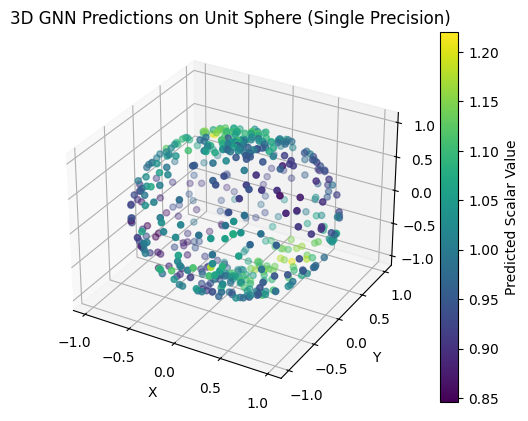

In [14]:
# Visualize predictions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=pred_float32.flatten(), cmap='viridis')
plt.colorbar(sc, label='Predicted Scalar Value')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D GNN Predictions on Unit Sphere (Single Precision)')
plt.savefig('predictions.png')
plt.show()

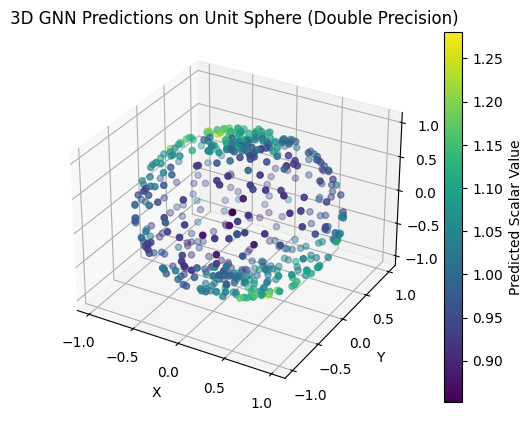

In [15]:
# Visualize predictions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=pred_float64.flatten(), cmap='viridis')
plt.colorbar(sc, label='Predicted Scalar Value')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D GNN Predictions on Unit Sphere (Double Precision)')
plt.savefig('predictions.png')
plt.show()

### Collect Outputs for the Report

We summarize the outputs to fill the report.

In [16]:
# Summary of outputs
print("Outputs for the report:")
print(f"MSE (float32): {mse_float32:.10f}")
print(f"MSE (float64): {mse_float64:.10f}")
print(f"MAE between float32 and float64 predictions: {mae:.10f}")
print(f"Rounding error: {rounding_error:.10f}")
print(f"Number of undirected edges: {num_undirected_edges}")
print(f"Sparsity: {sparsity:.4f}")
print(f"Degree range: {min_degree} to {max_degree}")
print(f"Number of connected components: {num_components}")

Outputs for the report:
MSE (float32): 0.0153041556
MSE (float64): 0.0145649973
MAE between float32 and float64 predictions: 0.0476326102
Rounding error: 0.0000000494
Number of undirected edges: 2374
Sparsity: 0.9905
Degree range: 8 to 14
Number of connected components: 1


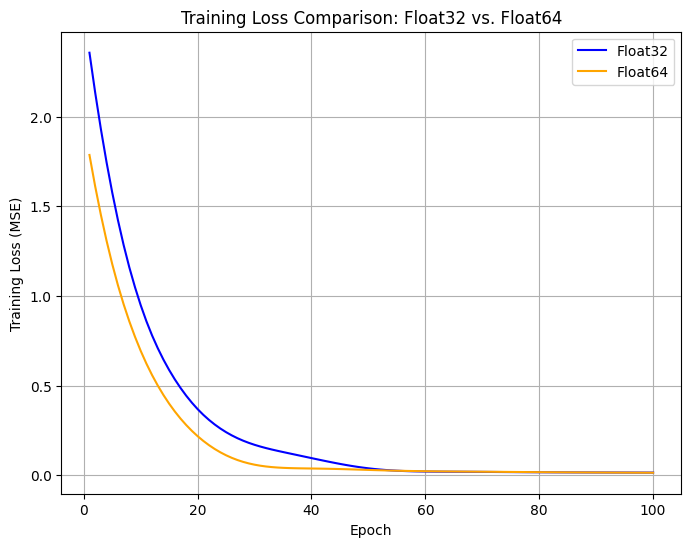

In [43]:
# Step 7: Plot Training Loss Comparison
plt.figure(figsize=(8, 6))
plt.plot(range(1, 101), losses_float32, label='Float32', color='blue')
plt.plot(range(1, 101), losses_float64, label='Float64', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Comparison: Float32 vs. Float64')
plt.legend()
plt.grid(True)
plt.savefig('training_loss_comparison.png')
plt.show()